In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [16]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [17]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [18]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [19]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# SETUP

In [20]:
CONFIG_DIR = '../app/'

In [21]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [22]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-25'
TETS_DATE = '2022-10-11'

In [23]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 1500],
            'buy_count_24H': [0, 3000],
            'sell_count_24H': [0, 5000],
            'cancel_count_24H': [0, 1000],
            #'token_all_activity_3H': [0, 30],
            #'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [24]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1665727196,70789,55620,sell,0x5dcfc1276ee97f73981e4619247039172b6112ac,NaN,0.23,sneakers,common,ranger,...,0.18,0.18,0.18,187.0,287.0,426.0,676.0,791.0,98.0,889.0
1,1665727163,70788,54501,sell,0xb60654707be9c645048495f472cb85b3500357a9,NaN,0.23,sneakers,common,sprinter,...,0.18,0.18,0.18,17.0,17.0,426.0,676.0,791.0,98.0,889.0
2,1665727151,70601,21135,cancel,0xa3a15c3b79a003fea5d7334335c87446290b7db8,NaN,NaN,sneakers,common,ranger,...,0.21,0.18,0.18,78.0,105.0,250.0,676.0,791.0,98.0,889.0
3,1665727151,70600,64880,cancel,0xa604dacd9a9965172e7a2c7281e85d514b35c4d3,NaN,NaN,sneakers,common,hiker,...,0.18,0.18,0.18,58.0,58.0,426.0,676.0,791.0,98.0,889.0
4,1665727148,70597,59371,cancel,0x3dd8c9bceee0c0b880f4e3f9cf4e56492b8c156f,NaN,NaN,sneakers,common,coacher,...,0.18,0.18,0.18,186.0,286.0,425.0,675.0,790.0,98.0,888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113542,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113543,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113544,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113545,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [26]:
data.columns[:-10]

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [27]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113547 entries, 0 to 113546
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  49712 non-null  float64
 1   time_ownership             49712 non-null  float64
 2   wallet_box_mint            49712 non-null  float64
 3   wallet_sneaker_mint        49712 non-null  float64
 4   time_level_up              72373 non-null  float64
 5   time_level_up_for_mint     76995 non-null  float64
 6   base_mint_price_amt        76995 non-null  float64
 7   base_mint_price_azy        76995 non-null  float64
 8   base_mint_price_bnb        66972 non-null  float64
dtypes: float64(9)
memory usage: 7.8 MB


In [28]:
data.genesis

0         False
1         False
2          True
3         False
4         False
          ...  
113542     True
113543    False
113544    False
113545    False
113546     True
Name: genesis, Length: 113547, dtype: bool

In [29]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
20,1665726968,70679,68251,buy,0x0541cb402f59e5a5ee1893f1ca56727e1249d266,0x053f2d9f4154e6ad4b70c1bd3dc69d057f6adfc5,0.20,sneakers,common,hiker,...,0.18,0.18,0.18,61.0,61.0,427.0,678.0,794.0,99.0,893.0
34,1665726841,70645,49444,buy,0x924e6893647387ca4dfe5536c0ae098a7c6ba1a8,0xc865da47eab66621fc98163c86de39cdc072ef1f,0.18,sneakers,common,sprinter,...,0.18,0.18,0.18,188.0,287.0,429.0,681.0,799.0,99.0,898.0
36,1665726834,70680,66862,buy,0x0541cb402f59e5a5ee1893f1ca56727e1249d266,0x053f2d9f4154e6ad4b70c1bd3dc69d057f6adfc5,0.20,sneakers,common,hiker,...,0.18,0.18,0.18,75.0,287.0,429.0,681.0,799.0,99.0,898.0
40,1665726782,70650,61490,buy,0x24ae00ec175fd6c1790f7256f63ae19e539ce7a5,0x053f2d9f4154e6ad4b70c1bd3dc69d057f6adfc5,0.18,sneakers,common,sprinter,...,0.18,0.18,0.18,76.0,289.0,431.0,682.0,802.0,99.0,901.0
63,1665726607,70707,56503,buy,0x0541cb402f59e5a5ee1893f1ca56727e1249d266,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.18,sneakers,common,ranger,...,0.18,0.18,0.18,63.0,63.0,433.0,684.0,805.0,99.0,904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113484,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113507,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113521,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113526,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [30]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 2829 | expected: 1000


In [31]:
data['mint'].isna().sum()

0

In [32]:
data[data['level'] == 9]['mint'].value_counts()

2.0    381
3.0    102
0.0     94
1.0     52
4.0      3
Name: mint, dtype: int64

In [33]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
404,1665722097,69797,26181,buy,0x7dc04a71b53e3dc05070ce6ebb06253ec3192171,0x033296a1ac07b1f517fc9abde03a0094a11a7fa6,0.35,sneakers,common,ranger,...,0.18,0.17,0.17,4.0,16.0,439.0,692.0,815.0,99.0,914.0
1008,1665714811,70106,37911,buy,0x16340757f04d1a37ad288273d35bcea16897f81c,0x754ede71d5cab33b662dc5df4d3bdf31621bd5fd,0.29,sneakers,common,hiker,...,0.22,0.22,0.22,11.0,17.0,429.0,680.0,798.0,99.0,897.0
1688,1665703806,69723,26768,buy,0x69cbc2cc4e5470e06d50324c7329ca1df233af19,0x0c7583ff486f9c7e60535d5397b776b811fc18cd,0.48,sneakers,common,ranger,...,0.21,0.21,0.21,5.0,17.0,435.0,676.0,787.0,99.0,886.0
2015,1665699372,69362,18167,buy,0xf4943868ad0149b15651045235555d7f1d09f5d7,0xd6f80deb4351e4d890b1e11d220a27e56323266b,0.44,sneakers,common,coacher,...,0.23,0.21,0.21,8.0,45.0,260.0,689.0,805.0,101.0,906.0
2264,1665696284,69632,26181,buy,0x2dbb45c39d225764efaba29fba9e4fbf6127fd72,0x7dc04a71b53e3dc05070ce6ebb06253ec3192171,0.25,sneakers,common,ranger,...,0.19,0.19,0.19,4.0,18.0,435.0,702.0,813.0,101.0,914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108919,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109695,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110848,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111209,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18613 entries, 20 to 113540
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        18613 non-null  int64  
 1   mrk_id                                           18613 non-null  int64  
 2   token_id                                         18613 non-null  int64  
 3   event                                            18613 non-null  object 
 4   wallet_from                                      18507 non-null  object 
 5   wallet_to                                        18613 non-null  object 
 6   price                                            18613 non-null  float64
 7   item_type                                        18613 non-null  object 
 8   rarity                                           18613 non-null  object 
 9   sneaker_type              

In [35]:
data[['diff_prev_price', 'count_waller_buyer', 'count_holder',
       'count_sneaker', 'count_sneaker_type', 'count_new_sneaker_1d',
       'count_new_sneaker_7d', 'count_new_sneaker_14d',
       'count_new_sneaker_30d', 'ratio_sneaker_genesis',
       'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18613 entries, 20 to 113540
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   diff_prev_price                          11348 non-null  float64
 1   count_waller_buyer                       10960 non-null  float64
 2   count_holder                             10960 non-null  float64
 3   count_sneaker                            18613 non-null  object 
 4   count_sneaker_type                       18613 non-null  object 
 5   count_new_sneaker_1d                     18613 non-null  object 
 6   count_new_sneaker_7d                     18613 non-null  object 
 7   count_new_sneaker_14d                    18613 non-null  object 
 8   count_new_sneaker_30d                    18613 non-null  object 
 9   ratio_sneaker_genesis                    10960 non-null  float64
 10  mkr_floor__rarity_type_genesis_lvl_mint  109

In [36]:
data[['diff_prev_price', 'count_waller_buyer', 'count_holder',
       'count_sneaker', 'count_sneaker_type', 'count_new_sneaker_1d',
       'count_new_sneaker_7d', 'count_new_sneaker_14d',
       'count_new_sneaker_30d', 'ratio_sneaker_genesis',
       'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl']]

,diff_prev_price,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,ratio_sneaker_genesis,mkr_floor__rarity_type_genesis_lvl_mint,mrk_floor__rarity_type_genesis_lvl
20,NaN,676.0,9844.0,34166.0,10633.0,109.0,1156.0,3222.0,10375.0,0.569420,0.20,0.20
34,-0.37,681.0,9844.0,34166.0,8949.0,109.0,1156.0,3222.0,10375.0,0.569930,0.18,0.18
36,-0.06,681.0,9844.0,34166.0,10633.0,109.0,1156.0,3222.0,10375.0,0.569930,0.23,0.18
40,-0.42,681.0,9844.0,34166.0,8949.0,109.0,1156.0,3222.0,10375.0,0.564236,0.20,0.18
63,-0.02,683.0,9844.0,34166.0,9787.0,109.0,1156.0,3222.0,10377.0,0.561313,0.18,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...
113484,-0.03,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN,NaN
113507,-0.12,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN,NaN
113521,NaN,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN,NaN
113526,0.08,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN,NaN


In [37]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [38]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [39]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [40]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18613 entries, 20 to 113540
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        18613 non-null  int64  
 1   mrk_id                                           18613 non-null  int64  
 2   token_id                                         18613 non-null  int64  
 3   event                                            18613 non-null  object 
 4   wallet_from                                      18507 non-null  object 
 5   wallet_to                                        18613 non-null  object 
 6   price                                            18613 non-null  float64
 7   item_type                                        18613 non-null  object 
 8   rarity                                           18613 non-null  object 
 9   sneaker_type              

In [42]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
20,1665726968,70679,68251,buy,0x0541cb402f59e5a5ee1893f1ca56727e1249d266,0x053f2d9f4154e6ad4b70c1bd3dc69d057f6adfc5,0.20,sneakers,common,hiker,...,0.18,0.18,0.18,61.0,61.0,427.0,678.0,794.0,99.0,893.0
34,1665726841,70645,49444,buy,0x924e6893647387ca4dfe5536c0ae098a7c6ba1a8,0xc865da47eab66621fc98163c86de39cdc072ef1f,0.18,sneakers,common,sprinter,...,0.18,0.18,0.18,188.0,287.0,429.0,681.0,799.0,99.0,898.0
36,1665726834,70680,66862,buy,0x0541cb402f59e5a5ee1893f1ca56727e1249d266,0x053f2d9f4154e6ad4b70c1bd3dc69d057f6adfc5,0.20,sneakers,common,hiker,...,0.18,0.18,0.18,75.0,287.0,429.0,681.0,799.0,99.0,898.0
40,1665726782,70650,61490,buy,0x24ae00ec175fd6c1790f7256f63ae19e539ce7a5,0x053f2d9f4154e6ad4b70c1bd3dc69d057f6adfc5,0.18,sneakers,common,sprinter,...,0.18,0.18,0.18,76.0,289.0,431.0,682.0,802.0,99.0,901.0
63,1665726607,70707,56503,buy,0x0541cb402f59e5a5ee1893f1ca56727e1249d266,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.18,sneakers,common,ranger,...,0.18,0.18,0.18,63.0,63.0,433.0,684.0,805.0,99.0,904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113484,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113507,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113521,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113526,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [44]:
len(data)

18613

In [45]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

18404

уберем выбросы

In [46]:
data = data[(data['price'] > 0.1)]
len(data)

18404

In [47]:
data = data[~((data['genesis']) & (data['price'] < 0.1))].copy()
len(data)

18404

In [48]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

7324

In [49]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [50]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [51]:
#data['bin_level'].value_counts()

In [52]:
#data['bin_mint'].value_counts()

In [53]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [54]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [55]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [56]:
data['token_sell_activity_6H'].max()

12.0

In [57]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [58]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [59]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

7324

In [60]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [61]:
data[['diff_prev_price', 'count_waller_buyer', 'count_holder',
       'count_sneaker', 'count_sneaker_type', 'count_new_sneaker_1d',
       'count_new_sneaker_7d', 'count_new_sneaker_14d',
       'count_new_sneaker_30d', 'ratio_sneaker_genesis',
       'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl']]

,diff_prev_price,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,ratio_sneaker_genesis,mkr_floor__rarity_type_genesis_lvl_mint,mrk_floor__rarity_type_genesis_lvl
63010,NaN,543.0,8516.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,0.927374,0.72,0.72
63004,-0.30,544.0,8516.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,0.922222,0.83,0.83
62967,NaN,556.0,8512.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,0.897849,0.79,0.79
62959,-2.45,558.0,8510.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,1.113433,1.40,1.40
62952,-0.30,559.0,8509.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,1.134731,1.40,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.02,683.0,9844.0,34166.0,9787.0,109.0,1156.0,3222.0,10377.0,0.561313,0.18,0.18
40,-0.42,681.0,9844.0,34166.0,8949.0,109.0,1156.0,3222.0,10375.0,0.564236,0.20,0.18
36,-0.06,681.0,9844.0,34166.0,10633.0,109.0,1156.0,3222.0,10375.0,0.569930,0.23,0.18
34,-0.37,681.0,9844.0,34166.0,8949.0,109.0,1156.0,3222.0,10375.0,0.569930,0.18,0.18


In [62]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
63010,274.896552,0.063253,0.523060,0.616845
63004,274.480347,0.063272,0.523127,0.617867
62967,275.138925,0.064684,0.517872,0.611685
62959,275.486163,0.063216,0.520129,0.612306
62952,275.940389,0.063989,0.519163,0.610808
...,...,...,...,...
18810,273.322069,0.050194,0.226881,0.285755
18782,273.434528,0.050088,0.226759,0.285426
18776,273.002430,0.050296,0.226490,0.285735
18775,273.002430,0.050296,0.226490,0.285735


In [63]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [64]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
63010,274.896552,0.063253,0.523060,1.659379e+09,959900.0,10.0,11.0,900.0,1800.0,300.0,200.0,0.616845,2022-09-25 00:04:13
63004,274.480347,0.063272,0.523127,1.657800e+09,27840.0,14.0,14.0,360.0,1800.0,300.0,200.0,0.617867,2022-09-25 00:10:13
62967,275.138925,0.064684,0.517872,1.657806e+09,2415.0,12.0,12.0,0.0,1800.0,300.0,200.0,0.611685,2022-09-25 01:13:01
62959,275.486163,0.063216,0.520129,1.658163e+09,1748816.0,3.0,6.0,15180.0,1800.0,300.0,200.0,0.612306,2022-09-25 01:19:37
62952,275.940389,0.063989,0.519163,1.657805e+09,33500.0,4.0,5.0,9180.0,1800.0,300.0,200.0,0.610808,2022-09-25 01:41:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18810,273.322069,0.050194,0.226881,1.657812e+09,4794853.0,4.0,4.0,900.0,1800.0,300.0,200.0,0.285755,2022-10-10 23:22:11
18782,273.434528,0.050088,0.226759,1.657805e+09,9680.0,12.0,14.0,1260.0,1800.0,300.0,200.0,0.285426,2022-10-10 23:36:17
18776,273.002430,0.050296,0.226490,1.657803e+09,6069183.0,10.0,10.0,5460.0,1800.0,300.0,200.0,0.285735,2022-10-10 23:46:26
18775,273.002430,0.050296,0.226490,1.657803e+09,5824004.0,10.0,15.0,5460.0,1800.0,300.0,200.0,0.285735,2022-10-10 23:47:14


In [65]:
train_data.base_mint_price_azy.value_counts()

200.0     6900
800.0      417
3200.0       7
Name: base_mint_price_azy, dtype: int64

In [66]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    #'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'diff_prev_price', 
    #'count_waller_buyer', 
    #'count_holder',
    #'count_sneaker', 
    #'count_sneaker_type', 
    #'count_new_sneaker_1d',
    #'count_new_sneaker_7d', 
    #'count_new_sneaker_14d',
    #'count_new_sneaker_30d', 
    'ratio_sneaker_genesis',
    'mkr_floor__rarity_type_genesis_lvl_mint',
    'mrk_floor__rarity_type_genesis_lvl',
    ]

cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [67]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [68]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.29s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.28s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.28s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:09,  2.31s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:11,  2.29s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:13,  2.28s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:15,  2.27s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:18,  2.29s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:20,  2.32s/it]iteritems is deprec

In [69]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.898,0.0684
MAE,0.059,0.0090
MSE,0.064,0.0814
RMSE,0.222,0.1255
MAPE,0.071,0.0056


In [70]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.898,0.0684
MAE,0.059,0.0090
MSE,0.064,0.0814
RMSE,0.222,0.1255
MAPE,0.071,0.0056


In [71]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.873, 'MAE': 0.059, 'MSE': 0.064, 'RMSE': 0.254, 'MAPE': 0.071}

In [72]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


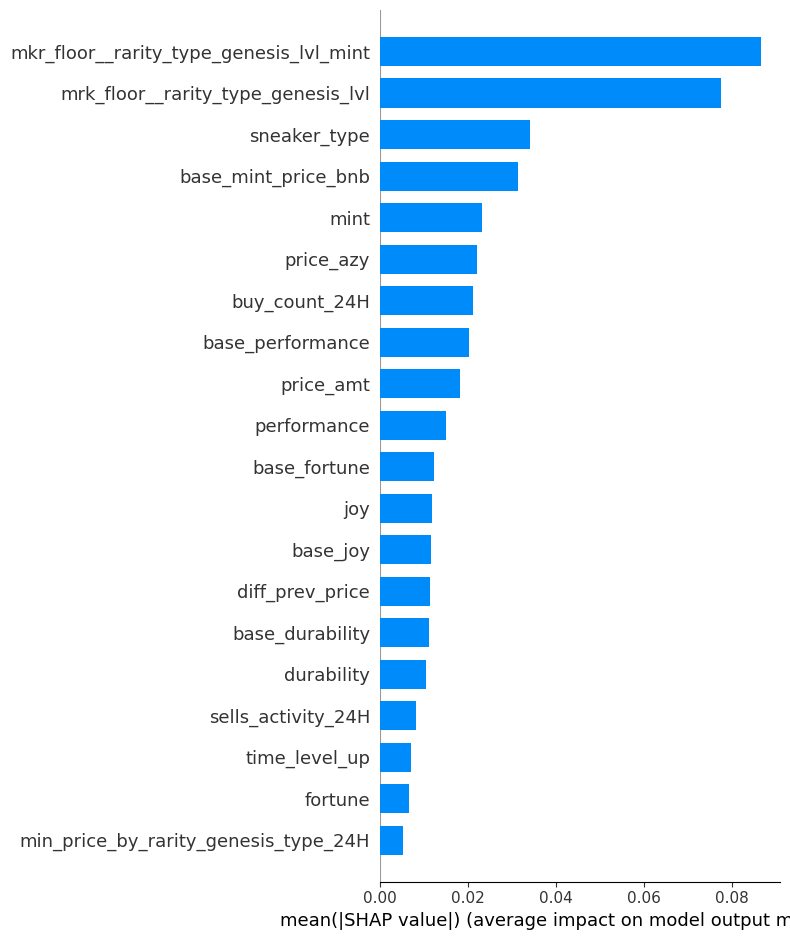

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [74]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.05608
0:	learn: 0.6856920	total: 4.4ms	remaining: 4.39s
1:	learn: 0.6591452	total: 7.25ms	remaining: 3.62s
2:	learn: 0.6349298	total: 10ms	remaining: 3.33s
3:	learn: 0.6121662	total: 12.5ms	remaining: 3.12s
4:	learn: 0.5910140	total: 14.7ms	remaining: 2.93s
5:	learn: 0.5710197	total: 17ms	remaining: 2.82s
6:	learn: 0.5502673	total: 19.4ms	remaining: 2.75s
7:	learn: 0.5307351	total: 21.7ms	remaining: 2.69s
8:	learn: 0.5119576	total: 23.9ms	remaining: 2.64s
9:	learn: 0.4942847	total: 26.2ms	remaining: 2.6s
10:	learn: 0.4778530	total: 28.5ms	remaining: 2.56s
11:	learn: 0.4620353	total: 30.8ms	remaining: 2.53s
12:	learn: 0.4481567	total: 33.1ms	remaining: 2.51s
13:	learn: 0.4345339	total: 35.3ms	remaining: 2.49s
14:	learn: 0.4211228	total: 37.6ms	remaining: 2.47s
15:	learn: 0.4092858	total: 39.8ms	remaining: 2.45s
16:	learn: 0.3970861	total: 42.2ms	remaining: 2.44s
17:	learn: 0.3860039	total: 44.4ms	remaining: 2.42s
18:	learn: 0.3756900	total: 46.5ms	remaining: 2.4s


In [75]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.913, 'MAE': 0.07, 'MSE': 0.025, 'RMSE': 0.159, 'MAPE': 0.208}

In [76]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.913, 'MAE': 0.07, 'MSE': 0.025, 'RMSE': 0.159, 'MAPE': 0.208}

## Fit full Model

In [77]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058054
0:	learn: 0.6623382	total: 3.21ms	remaining: 3.21s
1:	learn: 0.6348825	total: 6.87ms	remaining: 3.43s
2:	learn: 0.6115945	total: 9.83ms	remaining: 3.27s
3:	learn: 0.5885852	total: 12.3ms	remaining: 3.06s
4:	learn: 0.5663130	total: 14.9ms	remaining: 2.97s
5:	learn: 0.5440008	total: 17.5ms	remaining: 2.91s
6:	learn: 0.5240618	total: 20.2ms	remaining: 2.86s
7:	learn: 0.5043191	total: 22.7ms	remaining: 2.81s
8:	learn: 0.4858720	total: 25.2ms	remaining: 2.77s
9:	learn: 0.4693631	total: 27.7ms	remaining: 2.74s
10:	learn: 0.4528132	total: 30ms	remaining: 2.7s
11:	learn: 0.4373758	total: 32.4ms	remaining: 2.67s
12:	learn: 0.4238450	total: 35.1ms	remaining: 2.67s
13:	learn: 0.4097588	total: 37.4ms	remaining: 2.63s
14:	learn: 0.3962580	total: 39.7ms	remaining: 2.61s
15:	learn: 0.3836552	total: 42.5ms	remaining: 2.61s
16:	learn: 0.3724861	total: 44.9ms	remaining: 2.6s
17:	learn: 0.3619444	total: 47.3ms	remaining: 2.58s
18:	learn: 0.3513370	total: 49.9ms	remaining: 2.

### Test

In [78]:
i=1800

In [79]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                         common
sneaker_type                                   ranger
genesis                                         False
level                                             5.0
base_performance                                  9.0
base_fortune                                      3.6
base_joy                                          4.6
base_durability                                   1.2
performance                                      20.5
fortune                                           5.6
joy                                               7.1
durability                                        9.7
mint                                              2.0
buy_count_24H                                     753
min_price_all_24H                                 0.5
sells_activity_24H                            2.49004
min_price_by_rarity_genesis_type_24H              0.5
time_level_up                                   900.0
base_mint_price_bnb         

In [80]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 1235 | expected: 1000


In [81]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.519

In [82]:
data.iloc[i]['price']

0.49

iteritems is deprecated and will be removed in a future version. Use .items instead.


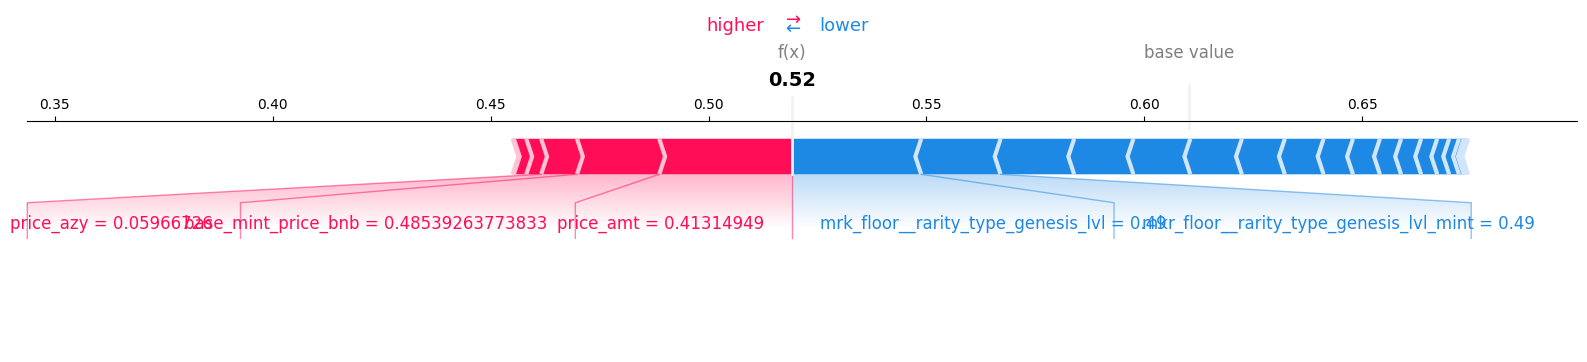

In [83]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [84]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [85]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [86]:
X.genesis.value_counts()

False    6234
True     2882
Name: genesis, dtype: int64

In [87]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,hiker,False,5.0,7.0,2.2,5.4,3.7,25.5,3.2,7.9,5.7,2.0
1,common,sprinter,False,3.0,6.0,7.5,2.1,5.9,14.8,9.9,3.7,8.7,0.0
2,common,hiker,False,0.0,1.8,5.3,8.6,7.3,1.8,5.3,8.6,7.3,0.0
3,common,sprinter,True,22.0,9.3,5.7,8.5,8.2,83.1,18.1,27.5,37.8,2.0
4,common,sprinter,True,17.0,5.5,7.6,3.0,7.8,62.2,21.2,11.1,22.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9111,common,ranger,False,0.0,1.4,2.9,9.8,7.4,1.4,2.9,9.8,7.4,0.0
9112,common,sprinter,False,5.0,9.3,1.3,6.5,6.3,26.8,1.8,10.0,11.3,0.0
9113,common,hiker,False,5.0,1.2,6.0,3.7,5.6,1.7,24.0,5.7,8.6,0.0
9114,common,sprinter,False,5.0,8.4,5.8,4.9,9.8,27.4,8.8,7.4,14.8,2.0


In [88]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.95s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.93s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.93s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:07,  1.95s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:09,  1.94s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:11,  1.95s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:13,  1.94s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:15,  1.94s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:17,  1.95s/it]iteritems is deprec

In [89]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.722,0.1069
MAE,0.176,0.0115
MSE,0.148,0.1264
RMSE,0.360,0.1357
MAPE,0.328,0.0145


In [90]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.722,0.1069
MAE,0.176,0.0115
MSE,0.148,0.1264
RMSE,0.360,0.1357
MAPE,0.328,0.0145


In [91]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.708, 'MAE': 0.176, 'MSE': 0.148, 'RMSE': 0.384, 'MAPE': 0.328}

In [92]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


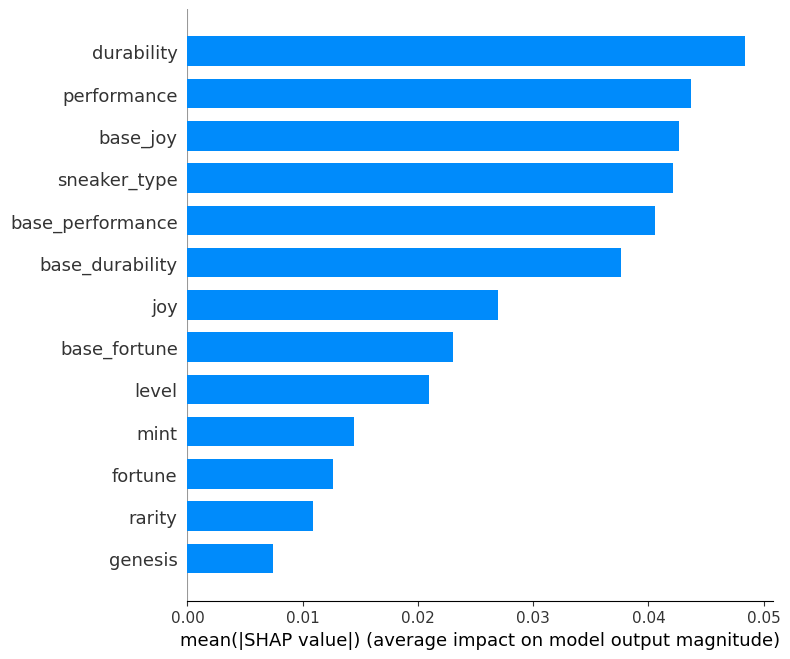

In [93]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [94]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [95]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.05608
0:	learn: 0.6873382	total: 3.63ms	remaining: 3.63s
1:	learn: 0.6647026	total: 6.67ms	remaining: 3.33s
2:	learn: 0.6432276	total: 9.23ms	remaining: 3.07s
3:	learn: 0.6232867	total: 11.3ms	remaining: 2.81s
4:	learn: 0.6042286	total: 13.3ms	remaining: 2.64s
5:	learn: 0.5863723	total: 15.1ms	remaining: 2.51s
6:	learn: 0.5693471	total: 17.2ms	remaining: 2.44s
7:	learn: 0.5533799	total: 19.1ms	remaining: 2.37s
8:	learn: 0.5385868	total: 21.2ms	remaining: 2.33s
9:	learn: 0.5244463	total: 23.1ms	remaining: 2.29s
10:	learn: 0.5112435	total: 25.1ms	remaining: 2.26s
11:	learn: 0.4989681	total: 27.1ms	remaining: 2.23s
12:	learn: 0.4870921	total: 29.1ms	remaining: 2.21s
13:	learn: 0.4764445	total: 31.2ms	remaining: 2.2s
14:	learn: 0.4666746	total: 33.2ms	remaining: 2.18s
15:	learn: 0.4567725	total: 35ms	remaining: 2.15s
16:	learn: 0.4476701	total: 37ms	remaining: 2.14s
17:	learn: 0.4387160	total: 39.1ms	remaining: 2.13s
18:	learn: 0.4302166	total: 41.4ms	remaining: 2.14

{'R2': -0.229, 'MAE': 0.319, 'MSE': 0.358, 'RMSE': 0.598, 'MAPE': 1.015}

## Fit full Base model

In [96]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058054
0:	learn: 0.6679933	total: 3.46ms	remaining: 3.46s
1:	learn: 0.6466832	total: 7.1ms	remaining: 3.54s
2:	learn: 0.6249140	total: 9.8ms	remaining: 3.26s
3:	learn: 0.6052696	total: 11.9ms	remaining: 2.96s
4:	learn: 0.5864673	total: 14ms	remaining: 2.79s
5:	learn: 0.5685794	total: 16ms	remaining: 2.65s
6:	learn: 0.5521623	total: 18.1ms	remaining: 2.57s
7:	learn: 0.5371278	total: 20.2ms	remaining: 2.51s
8:	learn: 0.5227830	total: 22.4ms	remaining: 2.47s
9:	learn: 0.5095323	total: 24.7ms	remaining: 2.44s
10:	learn: 0.4970247	total: 26.8ms	remaining: 2.41s
11:	learn: 0.4851216	total: 28.7ms	remaining: 2.37s
12:	learn: 0.4738187	total: 31.1ms	remaining: 2.36s
13:	learn: 0.4634117	total: 33.2ms	remaining: 2.33s
14:	learn: 0.4539833	total: 35.4ms	remaining: 2.32s
15:	learn: 0.4453035	total: 37.6ms	remaining: 2.31s
16:	learn: 0.4366564	total: 39.9ms	remaining: 2.31s
17:	learn: 0.4287957	total: 42.1ms	remaining: 2.3s
18:	learn: 0.4215908	total: 44.2ms	remaining: 2.28s

### Test

In [97]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [98]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

1.076

iteritems is deprecated and will be removed in a future version. Use .items instead.


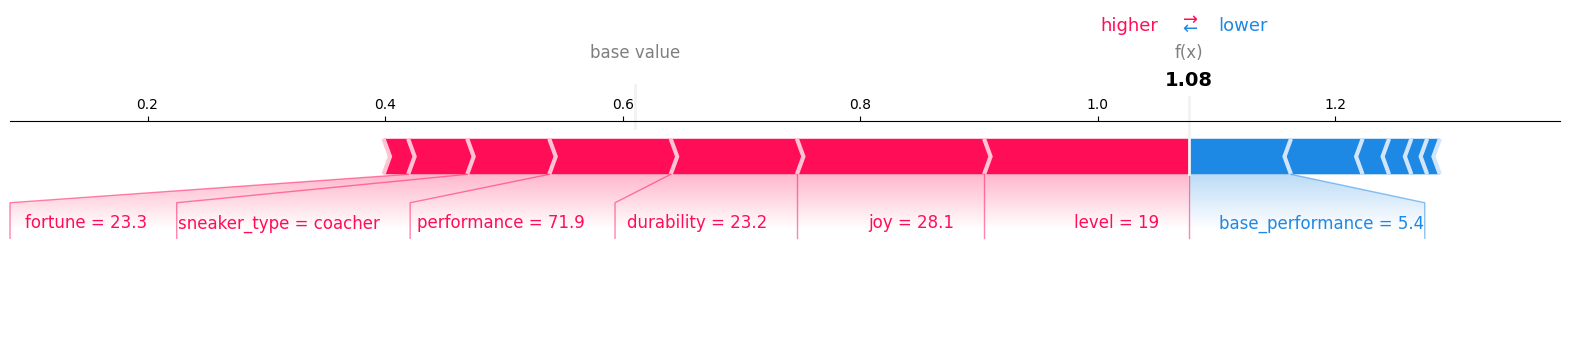

In [99]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

In [100]:
# sample = data[data['token_id'] == 20928][model.feature_names_][:1]
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(sample)
# shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
# #plt.savefig(f'explainer_{VERSION}.png', dpi=700)
# #plt.show()

In [101]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [102]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


In [103]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [104]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1665699645,69725,68668,buy,0xd7e5bcf276b337db6b0995eb0e62513370ab0445,0x25171dd23578ab8ce53dbf6127a5de29af151754,0.28,box,common,NaN,...,0.29,0.29,0.21,41.0,42.0,42.0,96.0,807.0,100.0,907.0
1,1665696074,69195,68945,buy,0xe93b3b61f3c54fdd073cba9c5baa65b778a5fa5a,0x6a3ae3b703776f6de567cca36139a2f3033a5cf9,0.30,box,common,NaN,...,0.29,0.29,0.19,42.0,43.0,43.0,97.0,804.0,101.0,905.0
2,1665695984,69609,69115,buy,0x03207642567238310ba8ef2cb7eba0ae8d2abe84,0x6a3ae3b703776f6de567cca36139a2f3033a5cf9,0.28,box,common,NaN,...,0.29,0.29,0.19,43.0,44.0,44.0,98.0,805.0,102.0,907.0
3,1665687713,62883,41605,buy,0x53fa7dee8d997e6b8834f39502f5a66075eaf6bd,0x709a9708035eca3d3d7520c9d4b447202fca1785,1.50,box,uncommon,NaN,...,1.78,1.78,0.21,5.0,5.0,5.0,5.0,764.0,103.0,867.0
4,1665642072,65629,1160,buy,0xef15d3c100d8319f0c58d4070a61a0d2db07018e,0xbde6b629ad25e93ce3a180fa913c7df7f0834c56,0.51,box,common,NaN,...,0.45,0.35,0.23,54.0,54.0,54.0,94.0,688.0,100.0,788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1349,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1350,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [106]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [107]:
len(data)

1353

In [108]:
len(data[data.date >= START_DATE])

379

In [109]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [110]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.663255e+09,13583.0,3.0,2.0,NaN,1800.0,300.0,200.0,0.600818
1,1.661749e+09,174375.0,4.0,3.0,NaN,1800.0,300.0,200.0,0.607289
2,1.658877e+09,957.0,12.0,16.0,NaN,1800.0,300.0,200.0,0.599755
3,1.661001e+09,537.0,12.0,18.0,NaN,1800.0,1200.0,800.0,2.376476
4,1.662148e+09,12226.0,1.0,0.0,NaN,1800.0,1200.0,800.0,2.378457
...,...,...,...,...,...,...,...,...,...
374,1.659372e+09,89114.0,4.0,4.0,NaN,1800.0,300.0,200.0,0.259974
375,1.659105e+09,202017.0,10.0,5.0,NaN,1800.0,1200.0,800.0,0.972760
376,1.659720e+09,1193.0,1.0,1.0,NaN,1800.0,300.0,200.0,0.245868
377,1.657808e+09,10915.0,19.0,13.0,NaN,1800.0,300.0,200.0,0.245868


In [111]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1664091033,39293,59092,buy,False,sprinter,sprinter,2022-09-25 07:30:33
1,1664092656,37700,57644,buy,False,sprinter,sprinter,2022-09-25 07:57:36
2,1664095476,39445,58245,buy,False,sprinter,hiker,2022-09-25 08:44:36
3,1664102839,39626,59075,buy,False,sprinter,sprinter,2022-09-25 10:47:19
4,1664103028,39386,58875,buy,False,hiker,hiker,2022-09-25 10:50:28
...,...,...,...,...,...,...,...,...
374,1665642072,65629,1160,buy,True,NaN,NaN,2022-10-13 06:21:12
375,1665687713,62883,41605,buy,False,hiker,hiker,2022-10-13 19:01:53
376,1665695984,69609,69115,buy,False,hiker,ranger,2022-10-13 21:19:44
377,1665696074,69195,68945,buy,False,hiker,ranger,2022-10-13 21:21:14


In [112]:
data.genesis.value_counts()

False    358
True      21
Name: genesis, dtype: int64

In [113]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [114]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [115]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [116]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1664091033,39293,59092,buy,0x745dc0ba8a797eedbc65d00e4b29caf3b0f76fc2,0xde7552c00667e9260f2c37ee558577c23451de15,0.95,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
1,1664092656,37700,57644,buy,0xc777c4126e7b4269b228ee7b86e04a607582afc2,0x7743426d5f9997ee6747b314da5e07fb8146f264,1.03,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
2,1664095476,39445,58245,buy,0x77249358662bcc12ee683685fcde8fa031e68c40,0x9e516819fc489c16988e2534838be35ef194d187,1.00,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
3,1664102839,39626,59075,buy,0xfb3b54458534a7d50439fd8062885f49523ec20d,0x3df43b2ba58581a54e28df689e36016dbd36b324,3.10,box,uncommon,NaN,...,0,0,0,0,0,0,0,1,0,0
4,1664103028,39386,58875,buy,0x72f49b95bf4da69c6fd2cb5bda518251dbc75ffe,0x3df43b2ba58581a54e28df689e36016dbd36b324,3.20,box,uncommon,NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1665642072,65629,1160,buy,0xef15d3c100d8319f0c58d4070a61a0d2db07018e,0xbde6b629ad25e93ce3a180fa913c7df7f0834c56,0.51,box,common,NaN,...,0,0,0,0,0,0,0,0,0,0
375,1665687713,62883,41605,buy,0x53fa7dee8d997e6b8834f39502f5a66075eaf6bd,0x709a9708035eca3d3d7520c9d4b447202fca1785,1.50,box,uncommon,NaN,...,0,0,0,0,0,0,0,0,1,0
376,1665695984,69609,69115,buy,0x03207642567238310ba8ef2cb7eba0ae8d2abe84,0x6a3ae3b703776f6de567cca36139a2f3033a5cf9,0.28,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0
377,1665696074,69195,68945,buy,0xe93b3b61f3c54fdd073cba9c5baa65b778a5fa5a,0x6a3ae3b703776f6de567cca36139a2f3033a5cf9,0.30,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0


In [117]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [118]:
data['ranger_hiker'].sum()

31

## FE

In [119]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [120]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [121]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [122]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.01it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.03it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:03,  2.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  2.01it/s]iteritems is deprec

In [123]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.781,0.1473
MAE,0.055,0.0242
MSE,0.020,0.0307
RMSE,0.119,0.0749
MAPE,0.069,0.0205


In [124]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.781,0.1473
MAE,0.055,0.0242
MSE,0.020,0.0307
RMSE,0.119,0.0749
MAPE,0.069,0.0205


In [125]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.782, 'MAE': 0.055, 'MSE': 0.02, 'RMSE': 0.14, 'MAPE': 0.069}

iteritems is deprecated and will be removed in a future version. Use .items instead.


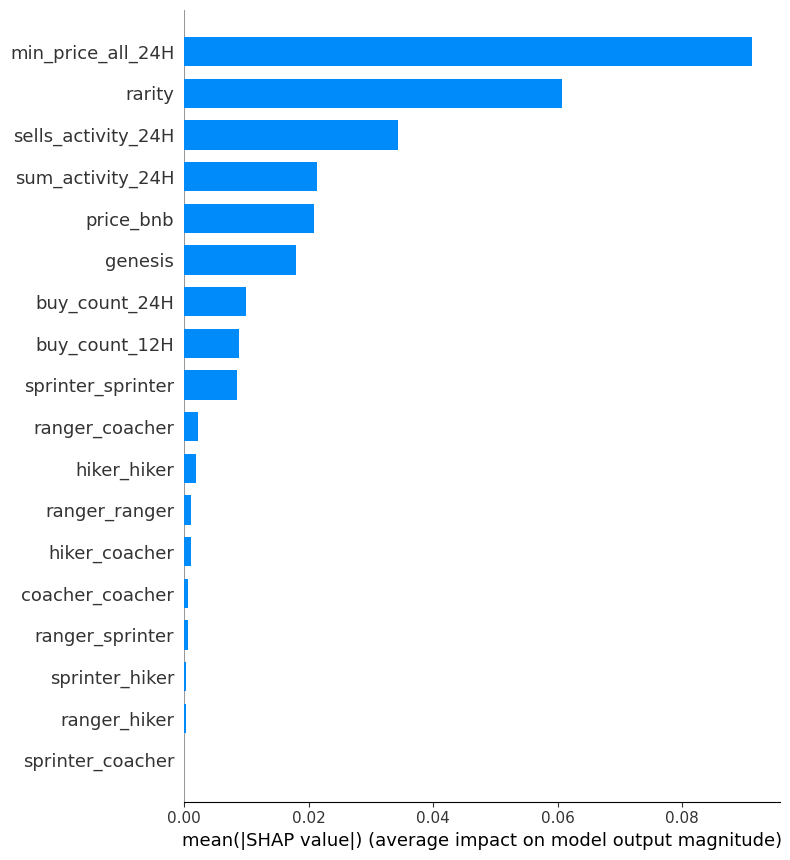

In [126]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [127]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.035124
0:	learn: 0.2950554	total: 421us	remaining: 422ms
1:	learn: 0.2894477	total: 1.3ms	remaining: 651ms
2:	learn: 0.2843566	total: 2.18ms	remaining: 725ms
3:	learn: 0.2794047	total: 3.01ms	remaining: 750ms
4:	learn: 0.2750945	total: 3.69ms	remaining: 735ms
5:	learn: 0.2716929	total: 4.37ms	remaining: 724ms
6:	learn: 0.2684728	total: 4.73ms	remaining: 671ms
7:	learn: 0.2637750	total: 5.4ms	remaining: 670ms
8:	learn: 0.2594518	total: 5.96ms	remaining: 657ms
9:	learn: 0.2550902	total: 6.33ms	remaining: 627ms
10:	learn: 0.2506653	total: 7ms	remaining: 630ms
11:	learn: 0.2476343	total: 7.28ms	remaining: 600ms
12:	learn: 0.2432910	total: 7.68ms	remaining: 583ms
13:	learn: 0.2388478	total: 8.29ms	remaining: 584ms
14:	learn: 0.2347542	total: 8.96ms	remaining: 589ms
15:	learn: 0.2305773	total: 9.57ms	remaining: 589ms
16:	learn: 0.2268972	total: 10.2ms	remaining: 589ms
17:	learn: 0.2234425	total: 10.8ms	remaining: 588ms
18:	learn: 0.2196267	total: 11.4ms	remaining: 587m

### Test

In [128]:
i = 250

In [129]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1665035634,
 'mrk_id': 52686,
 'token_id': 65952,
 'event': 'buy',
 'wallet_from': '0x280e67fa8cface666409234662182d67c322cc46',
 'wallet_to': '0xc285922299bcb92ccbd0ec68024ebf2c29caafd2',
 'price': 0.75,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 49272.0,
 'parent2': 63658.0,
 'genesis': False,
 'parent1_sneaker_type': 'hiker',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 296.62117826,
 'price_azy': 0.06853952,
 'price_amt': 0.36953932,
 'wallet_from_buy_count': 0.0,
 'wallet_from_all_count': 7.0,
 'token_all_activity_3H': 2.0,
 'token_sell_activity_6H': 1.0,
 'buy_count_12H': 7.0,
 'buy_count_24H': 23,
 'buy_count_48H': 33.0,
 'sell_count_12H': 19.0,
 'sell_count_24H': 58,
 'sell_count_48H': 108.0,
 'cancel_count_12H': 6.0,
 'cancel_count_24H':

In [130]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                     common
genesis                     False
buy_count_12H                 7.0
buy_count_24H                  23
sum_activity_24H              117
sells_activity_24H       2.521739
min_price_all_24H            0.73
price_bnb                     NaN
ranger_sprinter               NaN
ranger_hiker                  NaN
ranger_coacher                NaN
sprinter_hiker                  1
sprinter_coacher              NaN
hiker_coacher                 NaN
ranger_ranger                 NaN
sprinter_sprinter             NaN
hiker_hiker                   NaN
coacher_coacher               NaN
wallet_from_buy_count         0.0
wallet_from_all_count         7.0
dtype: object

In [131]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.806

In [132]:
data.iloc[i]['price']

0.75

In [133]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.949

In [134]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.634

# Box Base Model

In [135]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [136]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [137]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [138]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             379 non-null    object
 1   genesis            379 non-null    bool  
 2   ranger_sprinter    379 non-null    int64 
 3   ranger_hiker       379 non-null    int64 
 4   ranger_coacher     379 non-null    int64 
 5   sprinter_hiker     379 non-null    int64 
 6   sprinter_coacher   379 non-null    int64 
 7   hiker_coacher      379 non-null    int64 
 8   ranger_ranger      379 non-null    int64 
 9   sprinter_sprinter  379 non-null    int64 
 10  hiker_hiker        379 non-null    int64 
 11  coacher_coacher    379 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 33.1+ KB


In [139]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  5.07it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  5.06it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:00,  5.04it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:00,  5.02it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:00,  5.07it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  5.08it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:01,  5.08it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:01,  5.05it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:01,  4.97it/s]iteritems is deprec

In [140]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.132,0.6312
MAE,0.160,0.0348
MSE,0.076,0.0633
RMSE,0.257,0.0985
MAPE,0.253,0.0525


In [141]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.132,0.6312
MAE,0.160,0.0348
MSE,0.076,0.0633
RMSE,0.257,0.0985
MAPE,0.253,0.0525


In [142]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.159, 'MAE': 0.16, 'MSE': 0.076, 'RMSE': 0.275, 'MAPE': 0.253}

iteritems is deprecated and will be removed in a future version. Use .items instead.


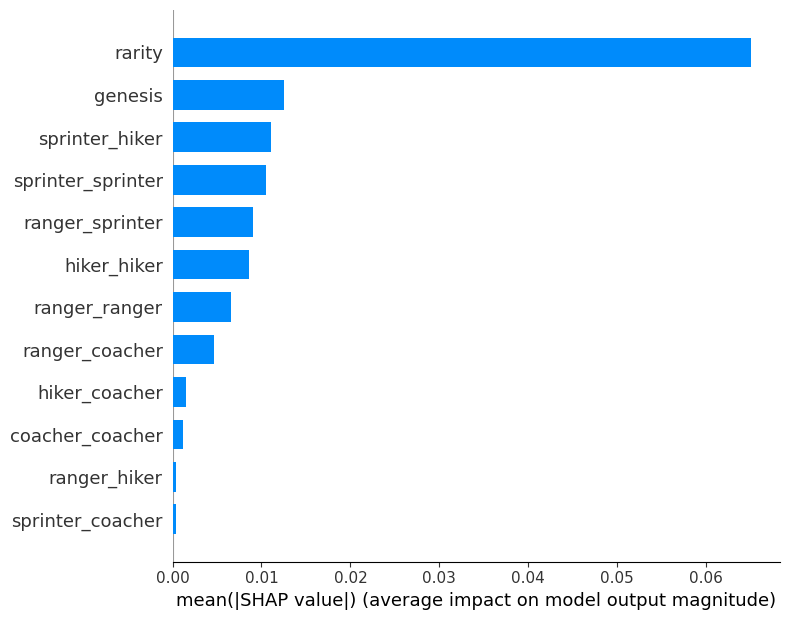

In [143]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [144]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.035124
0:	learn: 0.2970225	total: 199us	remaining: 199ms
1:	learn: 0.2943367	total: 323us	remaining: 161ms
2:	learn: 0.2917728	total: 450us	remaining: 150ms
3:	learn: 0.2894622	total: 657us	remaining: 164ms
4:	learn: 0.2870171	total: 794us	remaining: 158ms
5:	learn: 0.2847567	total: 884us	remaining: 146ms
6:	learn: 0.2826012	total: 969us	remaining: 138ms
7:	learn: 0.2805434	total: 1.21ms	remaining: 150ms
8:	learn: 0.2785854	total: 1.34ms	remaining: 147ms
9:	learn: 0.2765569	total: 1.48ms	remaining: 147ms
10:	learn: 0.2746180	total: 1.65ms	remaining: 148ms
11:	learn: 0.2729185	total: 1.75ms	remaining: 144ms
12:	learn: 0.2713005	total: 1.86ms	remaining: 141ms
13:	learn: 0.2697605	total: 1.96ms	remaining: 138ms
14:	learn: 0.2682951	total: 2.07ms	remaining: 136ms
15:	learn: 0.2669010	total: 2.18ms	remaining: 134ms
16:	learn: 0.2656745	total: 2.37ms	remaining: 137ms
17:	learn: 0.2644007	total: 2.49ms	remaining: 136ms
18:	learn: 0.2630245	total: 2.63ms	remaining: 136ms

## Test

In [145]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.375

In [146]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [147]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [148]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [149]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.657

In [150]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.68

In [151]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.68

In [152]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.841

In [153]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.682

In [154]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.707

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [155]:
# import ast
# import json

In [156]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [157]:
# print(json.dumps(json_data))

In [158]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [159]:
#output = json.loads(r.text)

In [160]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

In [161]:
{'token_id': 42349, 'item_type': 'sneakers', 'rarity': 'common', 'sneaker_type': 'sprinter', 'genesis': False, 'level': 8, 'base_performance': 2.7, 
'base_fortune': 6.3, 'base_joy': 9.4, 'base_durability': 4.9, 'performance': 25.1, 'fortune': 11.1, 'joy': 18.6, 'durability': 10.9, 'mint': 2, 
'parent1_sneaker_type': 'sprinter', 'parent2_sneaker_type': 'coacher', 'wallet_from_buy_count': None, 'wallet_from_all_count': None, 
'buy_count_12H': None, 
'buy_count_24H': 1398, 'buy_count_48H': None, 'sell_count_12H': None, 
'sell_count_24H': 3221, 
'sell_count_48H': None, 'cancel_count_12H': None, 
'cancel_count_24H': 1706, 'cancel_count_48H': None, 'min_price_all_24H': 0.5, 'min_price_by_rarity_genesis_type_level_mint_24H': None, 'min_price_by_rarity_genesis_type_level_mint_48H': 0.52, 'min_price_by_rarity_genesis_type_level_mint_72H': None, 'min_price_by_rarity_genesis_type_24H': 0.5, 'min_price_by_rarity_genesis_type_48H': None, 'min_price_by_rarity_genesis_type_72H': None, 'token_all_activity_3H': None, 'token_sell_activity_6H': None, 'price_bnb': 273.3326244499208, 'price_azy': 0.05407691570187973, 'price_amt': 0.24430650686382938, 'wallet_first_sneaker_time': None, 'time_ownership': None, 'wallet_box_mint': None, 'wallet_sneaker_mint': None, 'time_level_up': 2160, 'time_level_up_for_mint': 1800, 'base_mint_price_amt': 300.0, 'base_mint_price_azy': 200.0, 
'base_mint_price_bnb': 0.3077105609650145, 
'price': 0.31, 'explain_models': False}

{'token_id': 42349,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'sprinter',
 'genesis': False,
 'level': 8,
 'base_performance': 2.7,
 'base_fortune': 6.3,
 'base_joy': 9.4,
 'base_durability': 4.9,
 'performance': 25.1,
 'fortune': 11.1,
 'joy': 18.6,
 'durability': 10.9,
 'mint': 2,
 'parent1_sneaker_type': 'sprinter',
 'parent2_sneaker_type': 'coacher',
 'wallet_from_buy_count': None,
 'wallet_from_all_count': None,
 'buy_count_12H': None,
 'buy_count_24H': 1398,
 'buy_count_48H': None,
 'sell_count_12H': None,
 'sell_count_24H': 3221,
 'sell_count_48H': None,
 'cancel_count_12H': None,
 'cancel_count_24H': 1706,
 'cancel_count_48H': None,
 'min_price_all_24H': 0.5,
 'min_price_by_rarity_genesis_type_level_mint_24H': None,
 'min_price_by_rarity_genesis_type_level_mint_48H': 0.52,
 'min_price_by_rarity_genesis_type_level_mint_72H': None,
 'min_price_by_rarity_genesis_type_24H': 0.5,
 'min_price_by_rarity_genesis_type_48H': None,
 'min_price_by_rarity_genesis_type_

групировку делать по sell оредерам